# EDA

In [1]:
from function import *

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [22]:
# load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

---

### 1. Rough Modeling

In [3]:
# bias ogmantation
train = sm.add_constant(train)
test = sm.add_constant(test)

In [4]:
def make_features(category, continuous):
    
    '''
    카테고리 데이터를 표시하는 C()형태를 집어넣어주는 함수입니다.
    카티고리 데이터, 연속형 데이터를 + 표시로 묶었습니다.
    '''
    
    # make category feature
    category = list(map(lambda x: "C({})".format(x), category))
    category = " + ".join(category)
    
    # make continuous feature
    continuous = ' + '.join(continuous)
    
    # make final features
    features = continuous + ' + ' + category
    
    return features

In [5]:
category = ['vendor_id', 'store_and_fwd_flag', 
            'month', 'weekday', 'hour', 'holiday']
continuous = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'dist']

In [6]:
features = make_features(category, continuous)

In [7]:
def report(model) :
    """
    test storage
    """
    result = model.fit()
    result.summary()
    from statsmodels.stats.stattools import durbin_watson
    result_sets = pd.DataFrame(columns = ['R-square', 'Pb(Fstatics)', 'Pb(omnibus)', 'Pb(jb)', 'Dub-Wat', 'Cond.No.'])
    put = {
        'R-square' :round(result.rsquared, 3),
        'Pb(Fstatics)' : round(result.f_pvalue, 3),
        'Pb(omnibus)' : round(result.diagn['omnipv'], 3),
        'Pb(jb)' : round(result.diagn['jbpv'], 3), 
        'Dub-Wat': round(durbin_watson(result.wresid), 3),
        'Cond.No.' : round(result.diagn['condno'], 3),
    }
    
    
    result_sets.loc[len(result_sets)] = put

    return result_sets


In [8]:
# regression model
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                 5.273e+04
Date:                Sun, 20 May 2018   Prob (F-statistic):               0.00
Time:                        18:26:23   Log-Likelihood:            -1.0523e+06
No. Observations:             1458638   AIC:                         2.105e+06
Df Residuals:                 1458594   BIC:                         2.105e+06
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -13.3644      0.819    -16.309      0.000     -14.970     -11.758
C(vendor_id)[T.2]              0.0154      0.001     17.836      0.000       0.014       0.017
C(store_and_fwd_flag)[T.1]    -0.0355      0.006     -6.360      0.000      -0.046      -0.025
C(month)[T.2]                  0.0091      0.001      6.271      0.000       0.006       0.012
C(month)[T.3]                  0.0045      0.001      3.111      0.002       0.002       0.007
C(month)[T.4]                  0.0407      0.001     28.111      0.000       0.038       0.044
C(month)[T.5]                  0.0577      0.001     39.864      0.000       0.055       0.061
C(month)[T.6]                  0.0609      0.001     41.356      0.000       0.058       0.064
C(weekday)[T.1]                0.0818      0.002     50.392      0.000       0.079       0.085
C(weekday)[T.2]                0.1057      0.002     65.666      0.000       0.103       0.109
C(weekday)[T.3]                0.1125      0.002     70.443      0.000       0.109       0.116
C(weekday)[T.4]                0.1044      0.002     66.650      0.000       0.101       0.107
C(weekday)[T.5]                0.0127      0.002      7.906      0.000       0.010       0.016
C(weekday)[T.6]               -0.0845      0.002    -50.962      0.000      -0.088      -0.081
C(hour)[T.1]                  -0.0333      0.003     -9.998      0.000      -0.040      -0.027
C(hour)[T.2]                  -0.0655      0.004    -17.796      0.000      -0.073      -0.058
C(hour)[T.3]                  -0.1064      0.004    -26.148      0.000      -0.114      -0.098
C(hour)[T.4]                  -0.1967      0.005    -43.563      0.000      -0.206      -0.188
C(hour)[T.5]                  -0.3409      0.005    -73.979      0.000      -0.350      -0.332
C(hour)[T.6]                  -0.2300      0.003    -65.806      0.000      -0.237      -0.223
C(hour)[T.7]                   0.0267      0.003      8.790      0.000       0.021       0.033
C(hour)[T.8]                   0.2104      0.003     72.245      0.000       0.205       0.216
C(hour)[T.9]                   0.2504      0.003     86.283      0.000       0.245       0.256
C(hour)[T.10]                  0.2517      0.003     86.240      0.000       0.246       0.257
C(hour)[T.11]                  0.2821      0.003     97.660      0.000       0.276       0.288
C(hour)[T.12]                  0.2944      0.003    103.003      0.000       0.289       0.300
C(hour)[T.13]                  0.2850      0.003     99.651      0.000       0.279       0.291
C(hour)[T.14]                  0.2958      0.003    104.268      0.000       0.290       0.301
C(hour)[T.15]                  0.3004      0.003    105.132      0.000       0.295       0.306
C(hour)[T.16]                  0.2641      

In [9]:
report(model)

,R-square,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Cond.No.
0,0.609,0.0,0.0,0.0,1.999,237509.531


In [11]:
train.columns

Index(['const', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'month',
       'weekday', 'hour', 'holiday', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'dist', 'trip_duration'],
      dtype='object')

In [12]:
test.columns

Index(['const', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'month',
       'weekday', 'hour', 'holiday', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'dist'],
      dtype='object')

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
train_vif = train.drop(['trip_duration'], axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_vif.values, i) for i in range(train_vif.shape[1])]
vif["features"] = train_vif.columns
vif

,VIF Factor,features
0,3.933350e+06,const
1,1.096849e+00,vendor_id
2,1.090998e+00,passenger_count
3,1.007134e+00,store_and_fwd_flag
4,1.020835e+00,month
5,1.021712e+00,weekday
6,1.010686e+00,hour
7,1.031597e+00,holiday
8,2.716887e+00,pickup_longitude
9,1.439363e+00,pickup_latitude


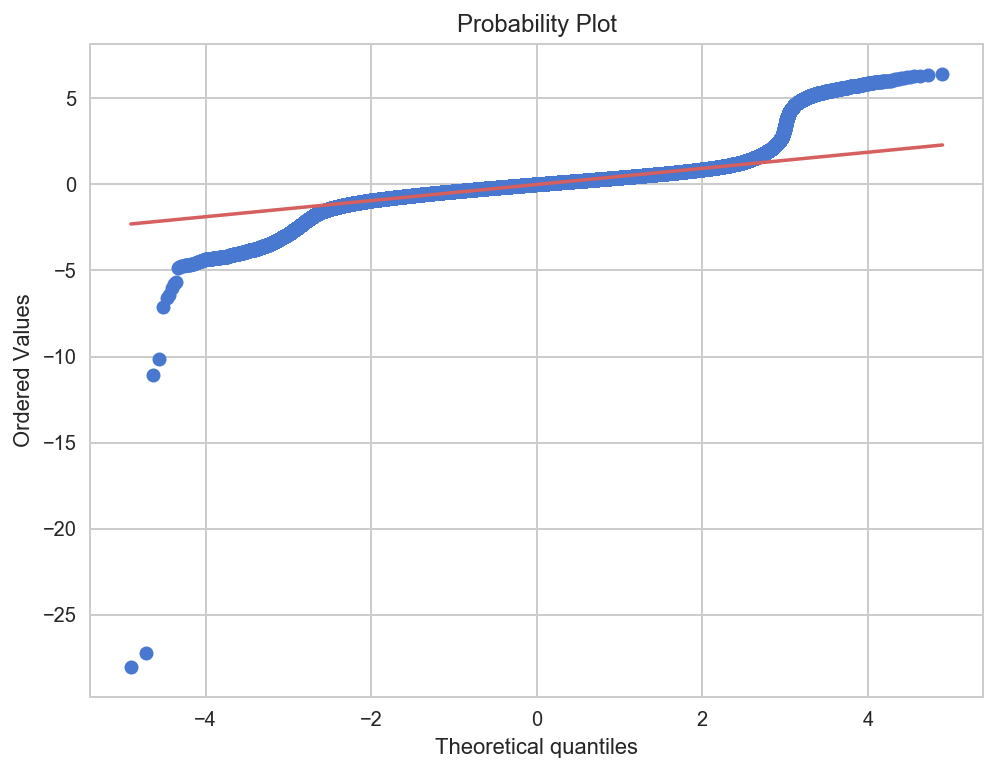

In [14]:
import scipy as sp
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result.resid, plot = plt)

plt.show()

In [15]:
import statsmodels.stats.api as sms

# Chi-square 확인
resid = sms.omni_normtest(result.resid)
for i in zip(['Chi^2', 'P-value'], resid):
    print("%-12s: %6.3f" % i)

Chi^2       : 458368.197
P-value     :  0.000


In [16]:
def cooks_distace(result, data, category=False, dropped=False):
    
    '''
    Cook's distance를 활용한 아웃라이어 제거 함수입니다.
    Cook's distance를 통해 제거된 데이터들은 dropped_data로 따로 저장했습니다.
    '''

    influence = result.get_influence()

    if category:
        fox_cr = 4 / (len(data) - result.df_model + 1)
    else:
        fox_cr = 4 / (len(data) - result.df_model)

    cooks_d2, pvals = influence.cooks_distance
    idx = np.where(cooks_d2 > fox_cr)[0]

    dropped_data = data.iloc[idx]
    data = data.drop(data.index[idx])
    data.reset_index(drop=True, inplace=True)

    if dropped:

        return data, dropped_data

    return data

### outlier 1회

In [17]:
train1 = cooks_distace(result, train)
train1.tail()

,const,vendor_id,passenger_count,store_and_fwd_flag,month,weekday,hour,holiday,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,trip_duration
1410898,1.0,2,4,0,4,4,13,0,-73.982201,40.745522,-73.994911,40.740170,0.799447,6.658011
1410899,1.0,1,1,0,1,6,7,0,-74.000946,40.747379,-73.970184,40.796547,1.952465,6.486161
1410900,1.0,2,1,0,4,4,6,0,-73.959129,40.768799,-74.004433,40.707371,2.176987,6.639876
1410901,1.0,1,1,0,1,1,15,0,-73.982079,40.749062,-73.974632,40.757107,0.738062,5.924256
1410902,1.0,1,1,0,4,1,14,0,-73.979538,40.781750,-73.972809,40.790585,0.757684,5.293305


In [18]:
# regression model
model1 =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = train1)
result1 = model1.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                 8.159e+04
Date:                Sun, 20 May 2018   Prob (F-statistic):               0.00
Time:                        18:28:52   Log-Likelihood:            -6.2504e+05
No. Observations:             1410903   AIC:                         1.250e+06
Df Residuals:                 1410859   BIC:                         1.251e+06
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -168.9287      1.192   -141.760      0.000    -171.264    -166.593
C(vendor_id)[T.2]             -0.0017      0.001     -2.573      0.010      -0.003      -0.000
C(store_and_fwd_flag)[T.1]    -0.0203      0.005     -4.073      0.000      -0.030      -0.011
C(month)[T.2]                  0.0093      0.001      8.272      0.000       0.007       0.011
C(month)[T.3]                  0.0047      0.001      4.227      0.000       0.003       0.007
C(month)[T.4]                  0.0444      0.001     39.835      0.000       0.042       0.047
C(month)[T.5]                  0.0630      0.001     56.507      0.000       0.061       0.065
C(month)[T.6]                  0.0642      0.001     56.561      0.000       0.062       0.066
C(weekday)[T.1]                0.0811      0.001     64.941      0.000       0.079       0.084
C(weekday)[T.2]                0.1045      0.001     84.376      0.000       0.102       0.107
C(weekday)[T.3]                0.1143      0.001     93.089      0.000       0.112       0.117
C(weekday)[T.4]                0.1032      0.001     85.519      0.000       0.101       0.106
C(weekday)[T.5]                0.0019      0.001      1.506      0.132      -0.001       0.004
C(weekday)[T.6]               -0.0957      0.001    -74.904      0.000      -0.098      -0.093
C(hour)[T.1]                  -0.0423      0.003    -16.417      0.000      -0.047      -0.037
C(hour)[T.2]                  -0.0701      0.003    -24.491      0.000      -0.076      -0.065
C(hour)[T.3]                  -0.1053      0.003    -32.947      0.000      -0.112      -0.099
C(hour)[T.4]                  -0.1755      0.004    -48.473      0.000      -0.183      -0.168
C(hour)[T.5]                  -0.3068      0.004    -83.917      0.000      -0.314      -0.300
C(hour)[T.6]                  -0.2082      0.003    -77.204      0.000      -0.213      -0.203
C(hour)[T.7]                   0.0385      0.002     16.393      0.000       0.034       0.043
C(hour)[T.8]                   0.2228      0.002     99.210      0.000       0.218       0.227
C(hour)[T.9]                   0.2645      0.002    118.119      0.000       0.260       0.269
C(hour)[T.10]                  0.2677      0.002    118.855      0.000       0.263       0.272
C(hour)[T.11]                  0.2992      0.002    134.218      0.000       0.295       0.304
C(hour)[T.12]                  0.3091      0.002    140.153      0.000       0.305       0.313
C(hour)[T.13]                  0.2980      0.002    135.087      0.000       0.294       0.302
C(hour)[T.14]                  0.3118      0.002    142.558      0.000       0.308       0.316
C(hour)[T.15]                  0.3177      0.002    144.261      0.000       0.313       0.322
C(hour)[T.16]                  0.2872      

In [19]:
report(model1)

,R-square,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Cond.No.
0,0.713,0.0,0.0,0.0,1.999,448730.675


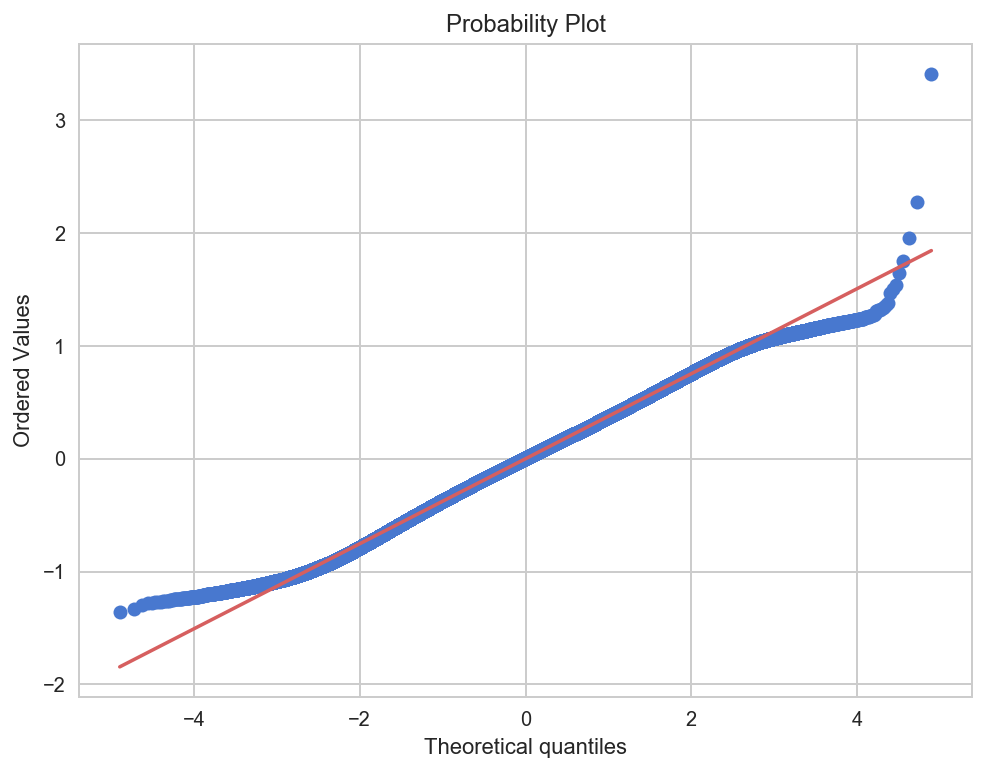

In [20]:
import scipy as sp
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result1.resid, plot = plt)

plt.show()

In [21]:
# Chi-square 확인
resid = sms.omni_normtest(result1.resid)
for i in zip(['Chi^2', 'P-value'], resid):
    print("%-12s: %6.3f" % i)

Chi^2       : 738.598
P-value     :  0.000


### submission

In [ ]:
y_hat = y_hat.apply(lambda x: int(round(np.exp(x), 0)))

In [41]:
y_hat.describe()

count    625134.000000
mean          8.687386
std           4.289173
min          -8.802130
25%           6.493448
50%           7.355469
75%           9.146584
max        1042.219931
dtype: float64

In [33]:
y_hat.apply(lambda x: int(round(2**x,0)))

OverflowError: (34, 'Result too large')

In [27]:
y_hat = result1.predict(test)
y_hat = y_hat.apply(lambda x: int(round(np.exp(x), 0)))
ans = pd.concat([submission['id'], y_hat], axis=1)
ans.rename(columns={'id':'id' , 0 :'trip_duration'}, inplace=True)
ans.tail()

OverflowError: cannot convert float infinity to integer

In [67]:
ans.to_csv('answer.csv', index = False)

In [105]:
y_hat.describe()

count     625134.0
unique    130842.0
top          431.0
freq         475.0
dtype: float64

In [104]:
y_hat = result1.predict(test)
y_hat = y_hat.apply(lambda x: (round(np.exp(x))),0)
y_hat

0                2923
1                3047
2                 705
3               36945
4                 448
5               12181
6                6268
7                4022
8         2.93054e+10
9                1130
10              24384
11                391
12                696
13               2494
14              42476
15              20647
16               6972
17               1081
18                319
19              42184
20                394
21               1301
22               1000
23              22685
24              34187
25             299053
26               2065
27                522
28        5.07928e+06
29             660952
             ...     
625104            613
625105            596
625106           1662
625107            706
625108         396767
625109           3776
625110            269
625111           9336
625112            647
625113           1113
625114            980
625115    1.78633e+09
625116           1762
625117    1.83479e+06
625118    

In [100]:
data1 = np.exp(data)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [103]:
data1 = data1.apply(lambda x: int(x))

OverflowError: cannot convert float infinity to integer

### outlier 2회

In [ ]:
train2 = cooks_distace(result1, train1)
train2.tail()

In [ ]:
# regression model
model2 =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = train2)
result2 = model2.fit()
result2.summary()

In [ ]:
report(model2)

In [ ]:
import scipy as sp
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result2.resid, plot = plt)

plt.show()

In [ ]:
# Chi-square 확인
resid = sms.omni_normtest(result2.resid)
for i in zip(['Chi^2', 'P-value'], resid):
    print("%-12s: %6.3f" % i)

### outlier 1회

In [22]:
train1 = cooks_distace(result, train)
train1.tail()

,const,vendor_id,passenger_count,store_and_fwd_flag,month,weekday,hour,holiday,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,trip_duration
1415915,1.0,2,4,0,4,4,13,0,-73.982201,40.745522,-73.994911,40.740170,0.799447,6.656727
1415916,1.0,1,1,0,1,6,7,0,-74.000946,40.747379,-73.970184,40.796547,1.952465,6.484635
1415917,1.0,2,1,0,4,4,6,0,-73.959129,40.768799,-74.004433,40.707371,2.176987,6.638568
1415918,1.0,1,1,0,1,1,15,0,-73.982079,40.749062,-73.974632,40.757107,0.738062,5.921578
1415919,1.0,1,1,0,4,1,14,0,-73.979538,40.781750,-73.972809,40.790585,0.757684,5.288267


In [ ]:
# regression model
model1 =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = train1)
result1 = model1.fit()
result1.summary()

In [ ]:
report(model1)

In [ ]:
import scipy as sp
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result1.resid, plot = plt)

plt.show()

In [21]:
# Chi-square 확인
resid = sms.omni_normtest(result1.resid)
for i in zip(['Chi^2', 'P-value'], resid):
    print("%-12s: %6.3f" % i)

Chi^2       : 1662.768
P-value     :  0.000


### outlier 1회

In [22]:
train1 = cooks_distace(result, train)
train1.tail()

,const,vendor_id,passenger_count,store_and_fwd_flag,month,weekday,hour,holiday,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,trip_duration
1415915,1.0,2,4,0,4,4,13,0,-73.982201,40.745522,-73.994911,40.740170,0.799447,6.656727
1415916,1.0,1,1,0,1,6,7,0,-74.000946,40.747379,-73.970184,40.796547,1.952465,6.484635
1415917,1.0,2,1,0,4,4,6,0,-73.959129,40.768799,-74.004433,40.707371,2.176987,6.638568
1415918,1.0,1,1,0,1,1,15,0,-73.982079,40.749062,-73.974632,40.757107,0.738062,5.921578
1415919,1.0,1,1,0,4,1,14,0,-73.979538,40.781750,-73.972809,40.790585,0.757684,5.288267


In [ ]:
# regression model
model1 =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = train1)
result1 = model1.fit()
result1.summary()

In [ ]:
report(model1)

In [ ]:
import scipy as sp
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result1.resid, plot = plt)

plt.show()

In [21]:
# Chi-square 확인
resid = sms.omni_normtest(result1.resid)
for i in zip(['Chi^2', 'P-value'], resid):
    print("%-12s: %6.3f" % i)

Chi^2       : 1662.768
P-value     :  0.000


### outlier 1회

In [22]:
train1 = cooks_distace(result, train)
train1.tail()

,const,vendor_id,passenger_count,store_and_fwd_flag,month,weekday,hour,holiday,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,trip_duration
1415915,1.0,2,4,0,4,4,13,0,-73.982201,40.745522,-73.994911,40.740170,0.799447,6.656727
1415916,1.0,1,1,0,1,6,7,0,-74.000946,40.747379,-73.970184,40.796547,1.952465,6.484635
1415917,1.0,2,1,0,4,4,6,0,-73.959129,40.768799,-74.004433,40.707371,2.176987,6.638568
1415918,1.0,1,1,0,1,1,15,0,-73.982079,40.749062,-73.974632,40.757107,0.738062,5.921578
1415919,1.0,1,1,0,4,1,14,0,-73.979538,40.781750,-73.972809,40.790585,0.757684,5.288267


In [ ]:
# regression model
model1 =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = train1)
result1 = model1.fit()
result1.summary()

In [ ]:
report(model1)

In [ ]:
import scipy as sp
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result1.resid, plot = plt)

plt.show()

In [21]:
# Chi-square 확인
resid = sms.omni_normtest(result1.resid)
for i in zip(['Chi^2', 'P-value'], resid):
    print("%-12s: %6.3f" % i)

Chi^2       : 1662.768
P-value     :  0.000


### outlier 1회

In [22]:
train1 = cooks_distace(result, train)
train1.tail()

,const,vendor_id,passenger_count,store_and_fwd_flag,month,weekday,hour,holiday,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,trip_duration
1415915,1.0,2,4,0,4,4,13,0,-73.982201,40.745522,-73.994911,40.740170,0.799447,6.656727
1415916,1.0,1,1,0,1,6,7,0,-74.000946,40.747379,-73.970184,40.796547,1.952465,6.484635
1415917,1.0,2,1,0,4,4,6,0,-73.959129,40.768799,-74.004433,40.707371,2.176987,6.638568
1415918,1.0,1,1,0,1,1,15,0,-73.982079,40.749062,-73.974632,40.757107,0.738062,5.921578
1415919,1.0,1,1,0,4,1,14,0,-73.979538,40.781750,-73.972809,40.790585,0.757684,5.288267


In [ ]:
# regression model
model1 =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = train1)
result1 = model1.fit()
result1.summary()

In [ ]:
report(model1)

In [ ]:
import scipy as sp
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result1.resid, plot = plt)

plt.show()

In [21]:
# Chi-square 확인
resid = sms.omni_normtest(result1.resid)
for i in zip(['Chi^2', 'P-value'], resid):
    print("%-12s: %6.3f" % i)

Chi^2       : 1662.768
P-value     :  0.000


### outlier 1회

In [22]:
train1 = cooks_distace(result, train)
train1.tail()

,const,vendor_id,passenger_count,store_and_fwd_flag,month,weekday,hour,holiday,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,trip_duration
1415915,1.0,2,4,0,4,4,13,0,-73.982201,40.745522,-73.994911,40.740170,0.799447,6.656727
1415916,1.0,1,1,0,1,6,7,0,-74.000946,40.747379,-73.970184,40.796547,1.952465,6.484635
1415917,1.0,2,1,0,4,4,6,0,-73.959129,40.768799,-74.004433,40.707371,2.176987,6.638568
1415918,1.0,1,1,0,1,1,15,0,-73.982079,40.749062,-73.974632,40.757107,0.738062,5.921578
1415919,1.0,1,1,0,4,1,14,0,-73.979538,40.781750,-73.972809,40.790585,0.757684,5.288267


In [ ]:
# regression model
model1 =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = train1)
result1 = model1.fit()
result1.summary()

In [ ]:
report(model1)

In [ ]:
import scipy as sp
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result1.resid, plot = plt)

plt.show()

In [21]:
# Chi-square 확인
resid = sms.omni_normtest(result1.resid)
for i in zip(['Chi^2', 'P-value'], resid):
    print("%-12s: %6.3f" % i)

Chi^2       : 1662.768
P-value     :  0.000
